# SketchNet

This notebook is to develop ideas for a network architecture that learns to copy simple line drawings.

## Libraries

In [1]:
from matplotlib import pyplot as plt #For image plotting
import numpy as np #basic data types and methods
from skimage import draw   #To create shape arrays
import sys                 #Just in case
import cv2 #various computer vision tools
import math
from scipy.spatial.distance import cdist, cosine # distance metrics
from scipy.optimize import linear_sum_assignment # optimization functions

#import webcolors  #Module for working with color names and specifications

## Code for generating sketches

The idea is to create sketches from a simple vocabulary of straight lines. Each sketch will be composed of s strokes; each stroke will be a straight horizontal or vertical line, beginning at the end point of the previous line and forming a randomly-chosen right angle with it.

In [219]:
def make_shape(ns=10, strtbox=5, minlen = 5, maxlen = 15, picsize = 64):
    ######################
    #Given parameters, returns a np array with the corresponding image
    #and the sequence of XY coordinates associated with the image
    #
    #ns = number of strokes for image
    #strtbox = size of box definining starting location
    #minlen = minimum length for each stroke
    #maxlen = maximum length for each stroke
    #picsize = total size of image in pixels
    ######################
    
    data = np.zeros((picsize,picsize,3), dtype=np.uint8) #Array to hold image
    xy = np.zeros(shape=(ns+1, 2), dtype=np.uint8)       #Array to hold coordinate sequence
    
    xy[0,0] = picsize/2 - strtbox + np.random.choice(strtbox*2) #initial X
    xy[0,1] = picsize/2 - strtbox + np.random.choice(strtbox*2) #initial Y

    rlen = np.random.choice(maxlen-minlen, ns) + minlen #Stroke lengths
    rdir = np.random.choice(2,ns) * 2 -1 #stroke direction

    for i in np.arange(0,ns):
        xy[i+1,0] = xy[i,0] + (rlen[i] * rdir[i]) * (i % 2) 
        xy[i+1,1] = xy[i,1] + (rlen[i] * rdir[i]) * (1 - i % 2)
        
    xy[xy < 0] = 0 #Hard boundary
    xy[xy >= picsize-1] = picsize-1 #Hard boundary

    for i in np.arange(0,ns):
        rr, cc, val = draw.line_aa(xy[i,0], xy[i,1], xy[i+1,0], xy[i+1,1])
        data[rr,cc,0] = val*255
        data[rr,cc,1] = val*255
        data[rr,cc,2] = val*255
    
    return data, xy

In [1216]:
def get_shape_from_coord(xy, picsize = 64):
    ns = xy.shape[0] - 1 #Number of strokes
    o = np.zeros(shape=(picsize, picsize,3)) #Image array
    for i in np.arange(0,ns):
        rr, cc, val = draw.line_aa(xy[i,0], xy[i,1], xy[i+1,0], xy[i+1,1])
        print(rr,cc)
        o[rr,cc,0] = val*255
        o[rr,cc,1] = val*255
        o[rr,cc,2] = val*255
    
    o[o>254] = 254 #Clip to max value
    o = o/254
    return o

In [1293]:
def _get_shape_from_coord(xy, resize =False, picsize = 64, scale = 1):
    
    '''
    Takes a list of coordinates generated from creating multiple shapes
    '''
    
    break_inds = np.where(np.sum(np.diff(xy.tolist(), axis=0)!=0, axis=1)==2) ## get indices where both x and y change
    start=0 
    new_arrs=[] ## new array with individual parts
    for ind in iter(break_inds[0]):
        new_arrs.append(xy[start:ind+1])
        start=ind+1
        #print(start)
    
        
    if start!=len(xy)-1:
        new_arrs.append(xy[start:len(xy)-1])
        
    
    
    o = np.zeros(shape=(picsize, picsize ,3), dtype = np.uint8) ### create empty array for full image frame
    if resize==True:
        imsize = np.uint8(np.ceil(picsize*scale)) ## set size of sketch frame
        
        ## choose placement for image within frame
        star_ind_x = np.random.choice(picsize-imsize+1)
        end_ind_x = star_ind_x+imsize

        star_ind_y = np.random.choice(picsize-imsize+1)
        end_ind_y = star_ind_y+imsize
        
        _o = np.zeros(shape=(imsize,imsize,3), dtype = np.uint8) ### create empty array for sketch
        
        for j in range(len(new_arrs)):
            plot_arr= np.uint8(np.ceil(new_arrs[j]*scale))
            for i in np.arange(0,len(plot_arr)-1):
                rr, cc= draw.line(plot_arr[i,0], plot_arr[i,1], plot_arr[i+1,0], plot_arr[i+1,1])
                _o[rr,cc,0] = 255
                _o[rr,cc,1] = 255
                _o[rr,cc,2] = 255
        ## Place sketch within image frame      
        o[star_ind_x:end_ind_x,star_ind_y:end_ind_y] = o[star_ind_x:end_ind_x,star_ind_y:end_ind_y]+_o
        
    else:
        for j in range(len(new_arrs)):
            plot_arr= new_arrs[j]
            for i in np.arange(0,len(plot_arr)-1):
                rr, cc= draw.line(plot_arr[i,0], plot_arr[i,1], plot_arr[i+1,0], plot_arr[i+1,1])
                o[rr,cc,0] = 255
                o[rr,cc,1] = 255
                o[rr,cc,2] = 255
    o[o>254] = 254 #Clip to max value
    o = o/254
    scaled_coords = xy*scale+[star_ind_x,star_ind_y]
    return o,scaled_coords



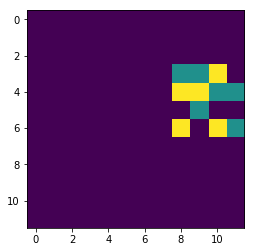

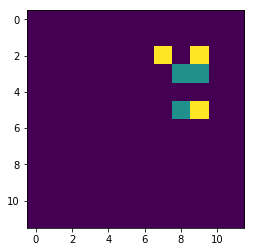

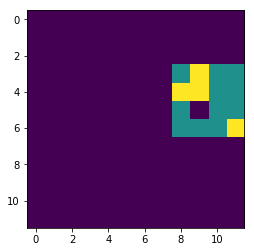

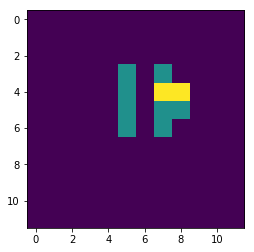

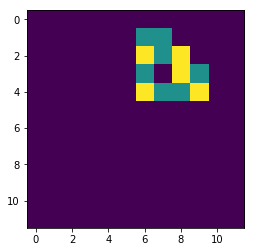

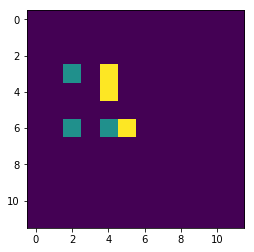

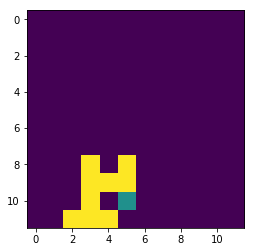

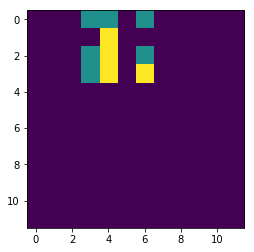

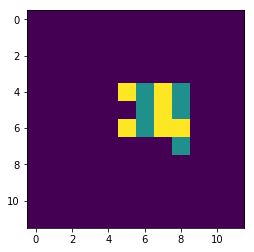

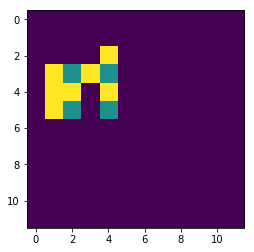

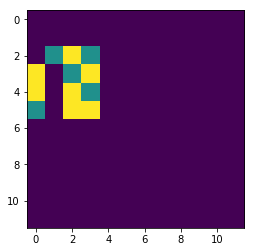

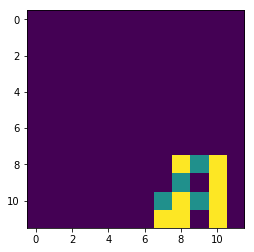

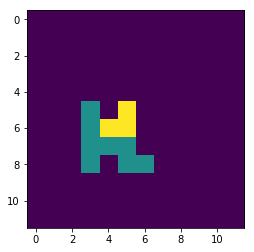

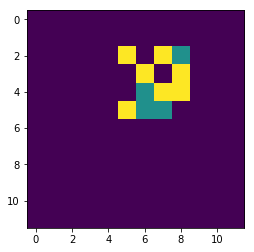

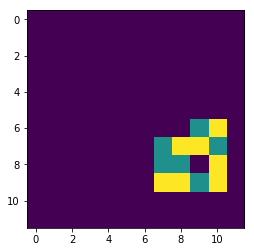

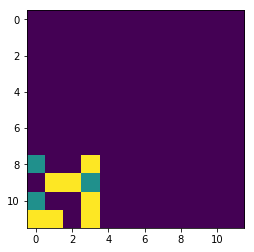

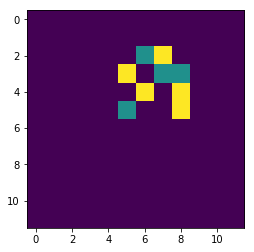

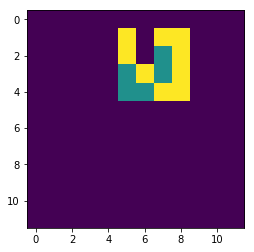

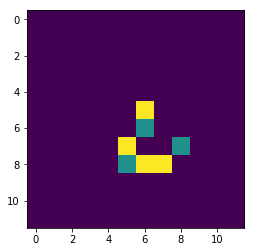

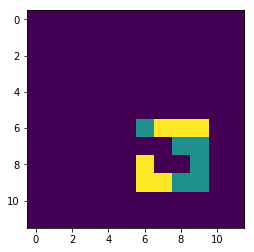

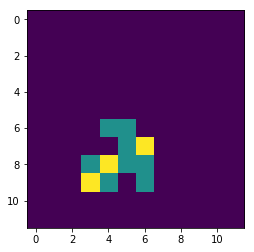

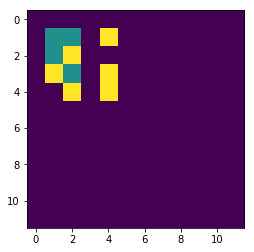

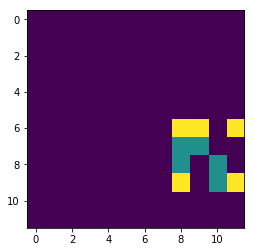

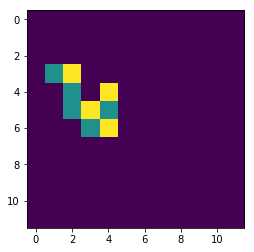

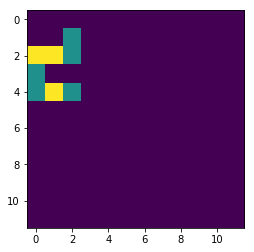

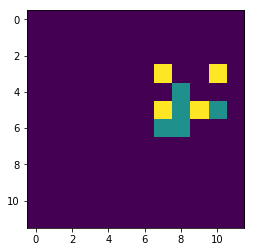

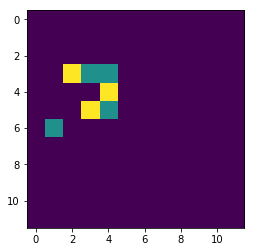

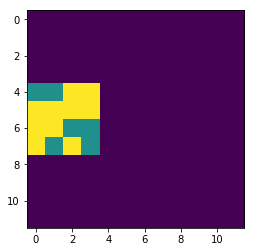

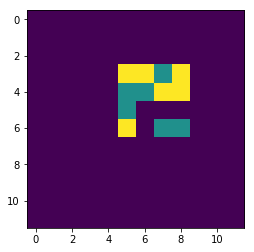

In [1110]:
for i in np.arange(1,30):
    picsize = 12
    scale = 0.3
    a=np.zeros(shape=(picsize,picsize))
    imsize = np.uint8(np.ceil(picsize*scale))
    star_ind_x = np.random.choice(picsize-imsize+1)
    end_ind_x = star_ind_x+imsize

    star_ind_y = np.random.choice(picsize-imsize+1)
    end_ind_y = star_ind_y+imsize


    b=np.random.choice(3,16).reshape(imsize,imsize)

    a[star_ind_x:end_ind_x,star_ind_y:end_ind_y] = a[star_ind_x:end_ind_x,star_ind_y:end_ind_y]+b
    a
    plt.imshow(a)
    plt.show()


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24


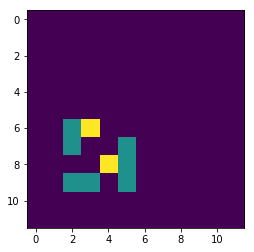

In [1098]:

b=np.random.choice(3,16).reshape(imsize,imsize)
 
a[star_ind_x:end_ind_x,star_ind_y:end_ind_y] = a[star_ind_x:end_ind_x,star_ind_y:end_ind_y]+b
a
plt.imshow(a)


In [1095]:
imsize

4

In [1096]:
np.ceil(picsize*scale)

4.0

In [340]:
a,b = make_shape()

In [1388]:
coords[0:5]


array([[ 0,  0],
       [ 0, 10],
       [10, 10],
       [10,  0],
       [ 0,  0]], dtype=uint8)

In [1416]:
b_inds = np.argwhere(coords[0:5][:,0]==np.amin(coords[0:5][:,0])).flatten()

np.unique(np.sort(coords[b_inds,:], axis=0), axis=0)[0]

array([0, 0], dtype=uint8)

In [1507]:
curr_move=5
b_inds = np.argwhere(coords[curr_move:curr_move+5][:,0]==np.amax(coords[curr_move:curr_move+5][:,0])).flatten()
b_inds

array([2, 3])

In [1506]:
coords

array([[ 0,  0],
       [ 0, 10],
       [10, 10],
       [10,  0],
       [ 0,  0],
       [10, 10],
       [10, 20],
       [20, 20],
       [20, 10],
       [10, 10],
       [ 0,  0],
       [ 0,  0],
       [ 0,  0],
       [ 0,  0],
       [ 0,  0],
       [ 0,  0]], dtype=uint8)

In [1548]:
point_set=np.zeros(shape=(16,2), dtype = np.uint8)


def square(xy,size=10,curr_move=0, init_coord = [10,10]):
    '''
    xy - set of coordinates of size total num strokes.
    curr move - The current stroke number
    init_coord - coordinates where the drawing should begin
    '''
    rlen = np.array([size]*4) #Stroke lengths
    rdir = np.array([1,1,-1,-1]) #stroke direction
    xy[curr_move,0] = init_coord[0]
    xy[curr_move,1] = init_coord[1]
    

    for i in np.arange(curr_move,curr_move+4):
        print((i-curr_move)%2)
        xy[i+1,0] = xy[i,0] + (rlen[i-curr_move] * rdir[i-curr_move]) * ((i-curr_move) % 2) 
        xy[i+1,1] = xy[i,1] + (rlen[i-curr_move] * rdir[i-curr_move]) * (1 - (i-curr_move) % 2)
        last_move = i+1
        
    b_inds = np.argwhere(xy[curr_move:curr_move+5][:,0]==np.amax(xy[curr_move:curr_move+5][:,0])).flatten()
    t_inds = np.argwhere(xy[curr_move:curr_move+5][:,0]==np.amin(xy[curr_move:curr_move+5][:,0])).flatten()
    
    tl = np.unique(np.sort(xy[curr_move:curr_move+5][t_inds,:], axis=0),axis=0)[0]
    tr = np.unique(np.sort(xy[curr_move:curr_move+5][t_inds,:], axis=0),axis=0)[1]
    
    bl = np.unique(np.sort(xy[curr_move:curr_move+5][b_inds,:], axis=0),axis=0)[0]
    br = xy[np.argmax(np.sum(xy, axis=1))]
    return(xy,br,bl,tr,tl,last_move)
        

In [1549]:
coords, br,bl,tr,tl,last_move= square(xy = point_set, curr_move=0)
print(coords,corner,last_move)

coords, br,bl,tr,tl,last_move = square(xy = coords, size=10, curr_move=last_move+1, init_coord=br)
print(coords,corner,last_move)

coords, br,bl,tr,tl,last_move = square(xy = coords, size=10, curr_move=last_move+1, init_coord=br)
print(coords,corner,last_move)

# coords, corner,last_move = square(xy = coords, curr_move=last_move+1,init_coord=corner )
# print(coords,corner,last_move)

0
1
0
1
[[10 10]
 [10 20]
 [20 20]
 [20 10]
 [10 10]
 [ 0  0]
 [ 0  0]
 [ 0  0]
 [ 0  0]
 [ 0  0]
 [ 0  0]
 [ 0  0]
 [ 0  0]
 [ 0  0]
 [ 0  0]
 [ 0  0]] [30 30] 4
0
1
0
1
[[10 10]
 [10 20]
 [20 20]
 [20 10]
 [10 10]
 [20 20]
 [20 30]
 [30 30]
 [30 20]
 [20 20]
 [ 0  0]
 [ 0  0]
 [ 0  0]
 [ 0  0]
 [ 0  0]
 [ 0  0]] [30 30] 9
0
1
0
1
[[10 10]
 [10 20]
 [20 20]
 [20 10]
 [10 10]
 [20 20]
 [20 30]
 [30 30]
 [30 20]
 [20 20]
 [30 30]
 [30 40]
 [40 40]
 [40 30]
 [30 30]
 [ 0  0]] [30 30] 14


In [1554]:
br

array([40, 40], dtype=uint8)

In [1555]:
bl

array([40, 30], dtype=uint8)

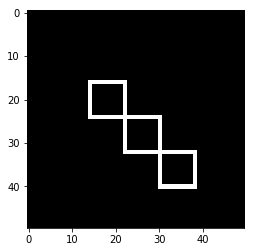

In [1553]:
l,sc = _get_shape_from_coord(xy=coords, picsize=50, resize=True, scale=0.8)
plt.imshow(l)

In [1551]:
tr

array([30, 40], dtype=uint8)

In [413]:
def rect(l,b, sp):

SyntaxError: unexpected EOF while parsing (<ipython-input-413-43306edf0ad6>, line 1)

In [ ]:
def r_angle(size,sp):

In [ ]:
def line(size,sp):

In [241]:
curr_point=3
xy= np.zeros(shape=(10,2))
for i in np.arange(curr_point,curr_point+4):
    xy[i+1,0] = 1
    xy[i+1,1] = 2

In [240]:
xy

array([[0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [1., 2.],
       [1., 2.],
       [1., 2.],
       [1., 2.],
       [0., 0.],
       [0., 0.]])

In [197]:
##get corner point
a = np.array([0,0,1,1,1,1,0,0,0]).reshape(3,3)
a
b = np.asarray(np.where(a==1))
b
b[:,np.argmax(np.sum(b, axis=0))]

array([1, 2])

In [223]:
a,b = make_shape()




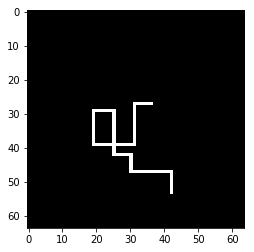

In [224]:
plt.imshow(a)

In [62]:
-np.diff(b.tolist(),axis=0)

array([[  0,  14],
       [ 14,   0],
       [  0,   6],
       [  9,   0],
       [  0,  14],
       [ -8,   0],
       [  0, -62],
       [ 13,   0],
       [  0,   0],
       [ -5,   0]])

In [61]:
b

array([[33, 35],
       [33, 21],
       [19, 21],
       [19, 15],
       [10, 15],
       [10,  1],
       [18,  1],
       [18, 63],
       [ 5, 63],
       [ 5, 63],
       [10, 63]], dtype=uint8)

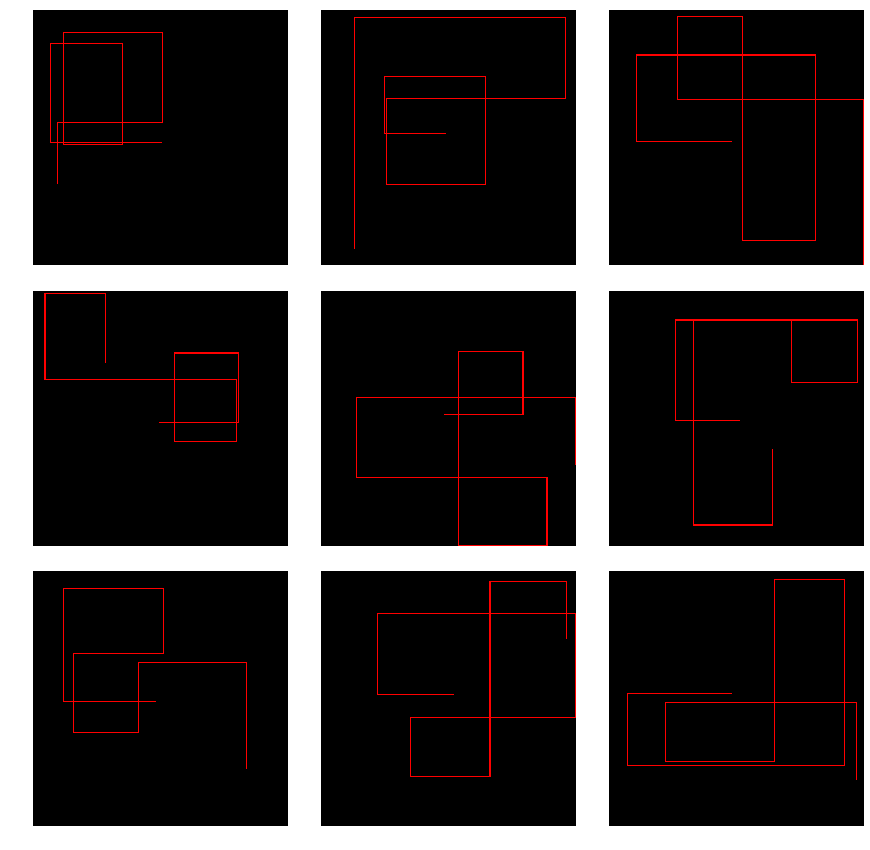

In [3]:
plt.figure(figsize=(15,15))
for i in range(0,3):
    for j in range(0,3):
        plt.subplot2grid((3,3), (i,j))
        tmpdat, tmpstroke = make_shape(ns=10, strtbox=5, minlen = 50, maxlen = 100, picsize = 224)
        fig = plt.imshow(tmpdat)
        plt.axis('off')
        plt.subplots_adjust(wspace=.1, hspace=.1)
plt.show()       

## Can an autoencoder learn these patterns?

### Libraries

In [4]:
##tensorflow###
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Concatenate
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import backend as K

/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

### Environment

Function to get a batch of images and an array indicating the xy coordinates for each image:

In [69]:
def get_batch(bsize=128, ns = 5, picsize=64, minlen = 5, maxlen = 15):
    xtrn = np.zeros(shape = (bsize,picsize,picsize,3)) #array for training image
    trnxy = np.zeros(shape=(bsize, ns+1, 2), dtype=np.uint8)  #array for sequence of training coordinates

    for i1 in np.arange(0,bsize):
        x, xy = make_shape(ns=ns,picsize=picsize, minlen=minlen, maxlen=maxlen)
        xtrn[i1,:,:,:] = x
        trnxy[i1,:,:] = xy

    xtrn[xtrn > 254] = 254 #Clip any high values
    xtrn = xtrn/255        #Normalize to 0-1
    
    return xtrn, trnxy

Visualize a set of randomly-generated images:

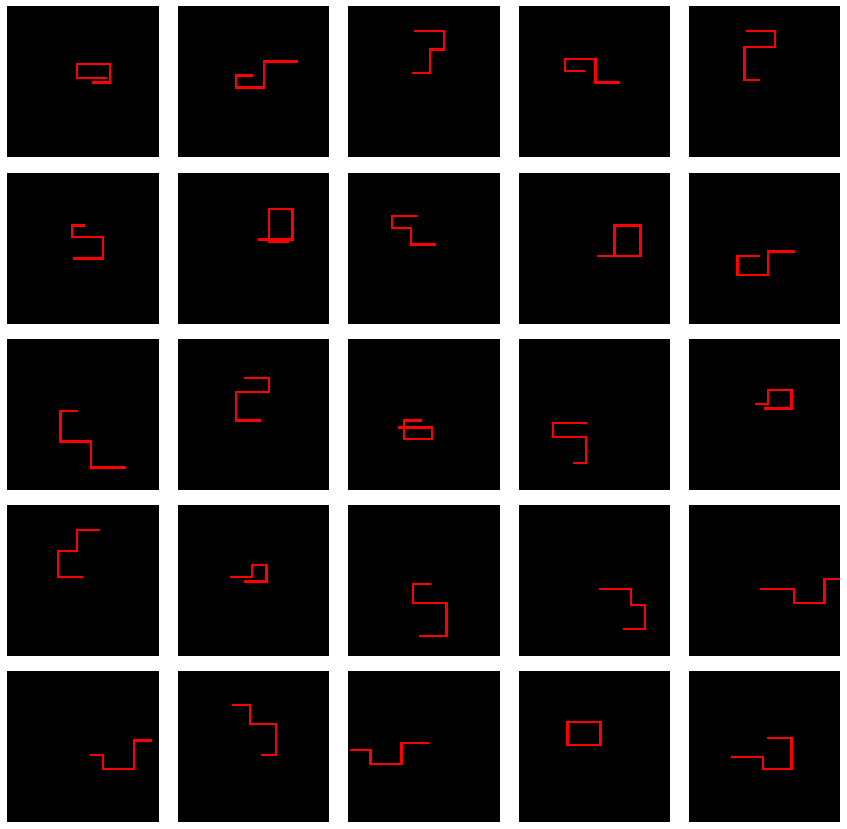

In [6]:
gsize = 5 #Size of image grid
tmp, tmp1 = get_batch(bsize=gsize**2)

plt.figure(figsize=(15,15))
for i in range(0,gsize):
    for j in range(0,gsize):
        plt.subplot2grid((gsize,gsize), (i,j))
        fig = plt.imshow(tmp[i*gsize + j,:,:,:])
        plt.axis('off')
        plt.subplots_adjust(wspace=.1, hspace=.1)
plt.show()     

Function that takes a sequence of coordinates and returns the np array containing the associated image

Display images generate this way (red channel) overlaid with associated bitmap (blue channel):

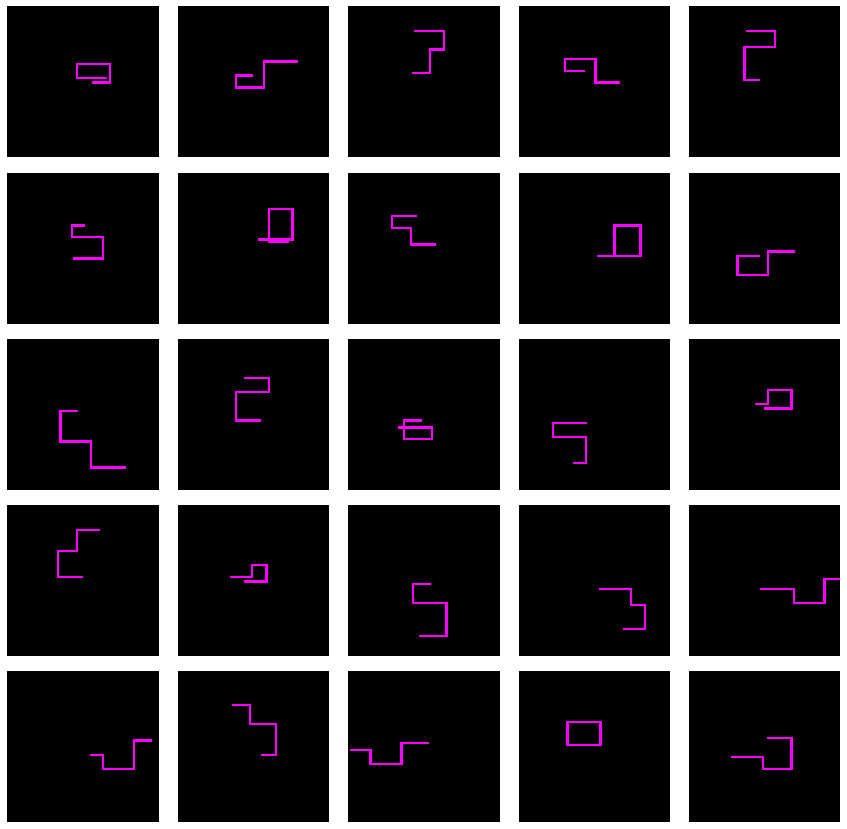

In [8]:
plt.figure(figsize=(15,15))
for i in range(0,5):
    for j in range(0,5):
        plt.subplot2grid((5,5), (i,j))
        tmp2 = get_shape_from_coord(tmp1[i*5 + j,:,:])
        tmp2[:,:,2] = tmp[i*5 + j,:,:,0]
        fig = plt.imshow(tmp2)
        plt.axis('off')
        plt.subplots_adjust(wspace=.1, hspace=.1)
plt.show()    

### Build autoassociator

In [ ]:
picsize = 64

input_img = Input(shape=(picsize,picsize,3))
x = Conv2D(8, (3,3), activation = 'relu', padding='same')(input_img)
x = MaxPooling2D((2,2), padding='same')(x)
x = Conv2D(16, (3,3), activation = 'relu', padding='same')(x)
x = MaxPooling2D((2,2), padding='same')(x)
x = Conv2D(32, (3,3), activation = 'relu', padding='same')(x)
#x = MaxPooling2D((2,2), padding='same')(x)
#x = Conv2D(64, (3,3), activation = 'relu', padding='same')(x)
encoded = MaxPooling2D((2,2), padding='same')(x)

In [ ]:
#x = Conv2D(64, (3,3), activation = 'relu', padding='same')(encoded)
#x = UpSampling2D((2,2))(x)
x = Conv2D(32, (3,3), activation = 'relu', padding='same')(encoded)
x = UpSampling2D((2,2))(x)
x = Conv2D(16, (3,3), activation = 'relu', padding='same')(x)
x = UpSampling2D((2,2))(x)
x = Conv2D(8, (3,3), activation = 'relu', padding='same')(x)
x = UpSampling2D((2,2))(x)
decoded = Conv2D(3, (3,3), activation = 'sigmoid', padding='same')(x)


In [ ]:
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer = 'adam', loss = 'binary_crossentropy')

In [ ]:
autoencoder.summary()

### Train and test

In [ ]:
H = autoencoder.fit(xtrn, xtrn, epochs = 100, batch_size = 50, validation_data=(xtst, xtst))

In [ ]:
gridsz = 3
s = np.random.choice(np.arange(0,2000),gridsz * gridsz)
tmp = autoencoder.predict(xtst[s,:,:,:])
tmp[:,:,:,2] = xtst[s,:,:,0]

plt.figure(figsize=(15,15))
for i in range(0,gridsz):
    for j in range(0,gridsz):
        plt.subplot2grid((gridsz,gridsz), (i,j))
        t = tmp[i*gridsz + j,:,:,:]
        fig = plt.imshow(t)
        plt.axis('off')
        plt.subplots_adjust(wspace=.1, hspace=.1)
plt.show()        

In [ ]:
#Save the model to a file
autoencoder.save('.\eas_dcnn_autoencoder.h5')

## What about an LSTM that generates sequences of strokes from a static image?

In [1200]:
from tensorflow.keras.layers import TimeDistributed, LSTM, SimpleRNN
from tensorflow.keras.models import Sequential

In [1199]:
eas = load_model('eas_lastm.h5')


OSError: Unable to open file (unable to open file: name = 'eas_lastm.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [1201]:
ns = 5 #Number of strokes
picsz = 64 #Dimensions of image

eas = Sequential()

eas.add(TimeDistributed(Conv2D(8,(3,3), activation = 'relu', padding='same'), input_shape = (ns, 64, 64,3)))
eas.add(TimeDistributed(MaxPooling2D((2,2),padding='same')))

eas.add(TimeDistributed(Conv2D(16,(3,3), activation = 'relu', padding='same')))
eas.add(TimeDistributed(MaxPooling2D((2,2),padding='same')))

eas.add(TimeDistributed(Conv2D(32,(3,3), activation = 'relu', padding='same')))
eas.add(TimeDistributed(MaxPooling2D((2,2),padding='same')))

eas.add(TimeDistributed(Flatten()))

eas.add(LSTM(32, return_sequences=True))

#eas.add(TimeDistributed(Dense(8, activation='relu')))

eas.add(TimeDistributed(Dense(2, activation = 'linear')))


In [1202]:
eas.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [1203]:
bsize = 128
ns=5
picsz=64

xtrn = np.zeros(shape=(bsize, ns, picsz, picsz, 3))
xtst = np.zeros(shape = (bsize, ns, picsz, picsz, 3))

#Get a batch of training data
x1, y1 = get_batch()
ytrn = y1.astype('float32')[:,1:6,:] - y1.astype('float32')[:,0:5,:]
for i in np.arange(0,ns):
    xtrn[:,i,:,:] = x1 #Copy input image to each timeslice


#Get a batch of testing data
x2, y2 = get_batch()
ytst = y2.astype('float32')[:,1:6,:] - y2.astype('float32')[:,0:5,:]
for i in np.arange(0,ns):
    xtst[:,i,:,:] = x2 #Copy input image to each timeslice


In [1204]:
x1, y1 = get_batch()

In [1205]:
ytst

array([[[  0.,  11.],
        [  9.,   0.],
        [  0.,  13.],
        [ -8.,   0.],
        [  0.,  -7.]],

       [[  0., -10.],
        [ 13.,   0.],
        [  0.,  10.],
        [ 14.,   0.],
        [  0.,   8.]],

       [[  0.,   7.],
        [-13.,   0.],
        [  0.,  -5.],
        [-14.,   0.],
        [  0.,   8.]],

       ...,

       [[  0.,  -5.],
        [ -9.,   0.],
        [  0.,   9.],
        [  6.,   0.],
        [  0.,   8.]],

       [[  0., -13.],
        [  6.,   0.],
        [  0.,  -6.],
        [  8.,   0.],
        [  0.,  54.]],

       [[  0.,  11.],
        [ -6.,   0.],
        [  0.,   7.],
        [  7.,   0.],
        [  0.,  -5.]]], dtype=float32)

In [1218]:
H = eas.fit(xtrn, ytrn, epochs = 200, batch_size = 50, validation_data=(xtst, ytst))

Train on 128 samples, validate on 128 samples
Epoch 1/200
128/128 [==============================] - 2s 13ms/sample - loss: 24.8347 - val_loss: 52.6307
Epoch 2/200
128/128 [==============================] - 2s 14ms/sample - loss: 24.6436 - val_loss: 52.5707
Epoch 3/200
128/128 [==============================] - 2s 16ms/sample - loss: 24.2271 - val_loss: 52.0757
Epoch 4/200
128/128 [==============================] - 2s 16ms/sample - loss: 23.9106 - val_loss: 52.5491
Epoch 5/200
128/128 [==============================] - 2s 14ms/sample - loss: 23.6240 - val_loss: 52.5145
Epoch 6/200
128/128 [==============================] - 1s 10ms/sample - loss: 23.4221 - val_loss: 51.7289
Epoch 7/200
128/128 [==============================] - 1s 10ms/sample - loss: 23.1166 - val_loss: 52.4589
Epoch 8/200
128/128 [==============================] - 1s 11ms/sample - loss: 22.8673 - val_loss: 52.0149
Epoch 9/200
128/128 [==============================] - 1s 10ms/sample - loss: 22.7189 - val_loss: 52.5488


128/128 [==============================] - 2s 17ms/sample - loss: 8.8250 - val_loss: 49.9908
Epoch 78/200
128/128 [==============================] - 2s 16ms/sample - loss: 8.2480 - val_loss: 50.0350
Epoch 79/200
128/128 [==============================] - 2s 16ms/sample - loss: 8.3429 - val_loss: 50.9141
Epoch 80/200
128/128 [==============================] - 2s 17ms/sample - loss: 8.1260 - val_loss: 50.4050
Epoch 81/200
128/128 [==============================] - 2s 19ms/sample - loss: 8.0349 - val_loss: 50.0862
Epoch 82/200
128/128 [==============================] - 2s 12ms/sample - loss: 7.9876 - val_loss: 50.2239
Epoch 83/200
128/128 [==============================] - 2s 13ms/sample - loss: 8.2596 - val_loss: 50.6368
Epoch 84/200
128/128 [==============================] - 2s 14ms/sample - loss: 8.0316 - val_loss: 50.9288
Epoch 85/200
128/128 [==============================] - 2s 12ms/sample - loss: 7.9485 - val_loss: 50.2684
Epoch 86/200
128/128 [==============================] - 2s 

Epoch 154/200
128/128 [==============================] - 2s 15ms/sample - loss: 4.3338 - val_loss: 51.9997
Epoch 155/200
128/128 [==============================] - 2s 15ms/sample - loss: 4.2562 - val_loss: 52.0219
Epoch 156/200
128/128 [==============================] - 1s 10ms/sample - loss: 4.2766 - val_loss: 52.1056
Epoch 157/200
128/128 [==============================] - 2s 12ms/sample - loss: 4.2089 - val_loss: 52.1808
Epoch 158/200
128/128 [==============================] - 1s 11ms/sample - loss: 4.1795 - val_loss: 52.0365
Epoch 159/200
128/128 [==============================] - 2s 14ms/sample - loss: 4.1568 - val_loss: 52.1498
Epoch 160/200
128/128 [==============================] - 2s 15ms/sample - loss: 4.1073 - val_loss: 52.1950
Epoch 161/200
128/128 [==============================] - 2s 14ms/sample - loss: 4.1045 - val_loss: 52.1793
Epoch 162/200
128/128 [==============================] - 2s 13ms/sample - loss: 4.0744 - val_loss: 52.2103
Epoch 163/200
128/128 [==============

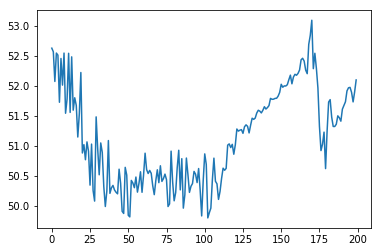

In [1219]:
plt.plot(H.history['val_loss'])

In [1223]:
#Save the model to a file
eas.save('.\eas_lstm.h5')

In [1224]:
pval = eas.predict(xtst)
predim = y2.astype('float32')
for i in np.arange(1,5):
    predim[:,i,:] = predim[:,i-1,:] + pval[:,i-1,:]
    
predim = predim.astype('uint8')

In [1243]:
predim[1,:,:]

array([[28, 29],
       [29, 19],
       [42, 21],
       [44, 32],
       [41, 36],
       [55, 37]], dtype=uint8)

[35 35 35 35 35 35 35 35 35 35 35] [31 30 29 28 27 26 25 24 23 22 21]
[35 35 34 34 33 33 32 32 31 31 30 29 30 29] [21 20 21 20 21 20 21 20 21 20 21 21 20 20]
[29 28 29 28 29 28 27 28 27 28 27 26 27 26 27 26] [20 20 21 21 22 22 22 23 23 24 24 24 25 25 26 26]
[26 27 26 27 26 27 28 27 28 27 28 29 28 29 28 29 30 29 30 29 30] [26 26 27 27 28 28 28 29 29 30 30 30 31 31 32 32 32 33 33 34 34]
[30 31 30 31 30 31 30 31 30 31 30 31 30 31 30 31 30 31 30 31 30 31 30 31
 30 31 30 31 30 31 31 32 31 32 31 32 31 32 31 32 31 32 31 32 31 32 31 32
 31 32 31 32 31 32 31 32 31 32 31 32] [34 34 35 35 36 36 37 37 38 38 39 39 40 40 41 41 42 42 43 43 44 44 45 45
 46 46 47 47 48 48 49 49 50 50 51 51 52 52 53 53 54 54 55 55 56 56 57 57
 58 58 59 59 60 60 61 61 62 62 63 63]
[35 34 35 34 35 34 35 34 33 34 33 34 33 34 33 32 33 32 33 32 33 32] [35 35 34 34 33 33 32 32 32 31 31 30 30 29 29 29 28 28 27 27 26 26]
[32 32 31 31 30 30 29 28 29 28 27 27 26 26 25 25 24 23 24 23] [26 27 26 27 26 27 26 26 27 27 27 28 27 28 27 

[31 30 31 30 29 30 29 28 29 28 27 28 27] [36 36 35 35 35 34 34 34 33 33 33 32 32]
[27 27 26 26 25 25 24 24 23 22 23 22 22 21 21 20 20 19 19 18 17 18 17] [32 33 32 33 32 33 32 33 32 32 33 33 34 33 34 33 34 33 34 33 33 34 34]
[17 16 17 16 17 16 17 16 15 16 15 16 15 16 15 14 15 14 15 14 15 14 13 14
 13 14 13 14 13] [34 34 35 35 36 36 37 37 37 38 38 39 39 40 40 40 41 41 42 42 43 43 43 44
 44 45 45 46 46]
[13 13 12 12 11 11 10 10  9  9  8  8  7  7  6  6  5  5  4  4  3  3  2  1
  2  1] [46 47 46 47 46 47 46 47 46 47 46 47 46 47 46 47 46 47 46 47 46 47 46 46
 47 47]
[1 2 1 2 1 2 1 2 1 2 1 2 2 3 2 3 2 3 2 3 2 3 3 4 3 4 3 4 3 4 3 4 4 5 4 5 4
 5 4 5 4 5 5 6 5 6 5 6 5 6 5 6 5 6] [47 47 46 46 45 45 44 44 43 43 42 42 41 41 40 40 39 39 38 38 37 37 36 36
 35 35 34 34 33 33 32 32 31 31 30 30 29 29 28 28 27 27 26 26 25 25 24 24
 23 23 22 22 21 21]
[27 26 27 26 27 26 27 26 27 26 27 26 27 26 27 26 27 26 27 26 27 26 27 26] [28 28 29 29 30 30 31 31 32 32 33 33 34 34 35 35 36 36 37 37 38 38 39 39]
[26 26 27

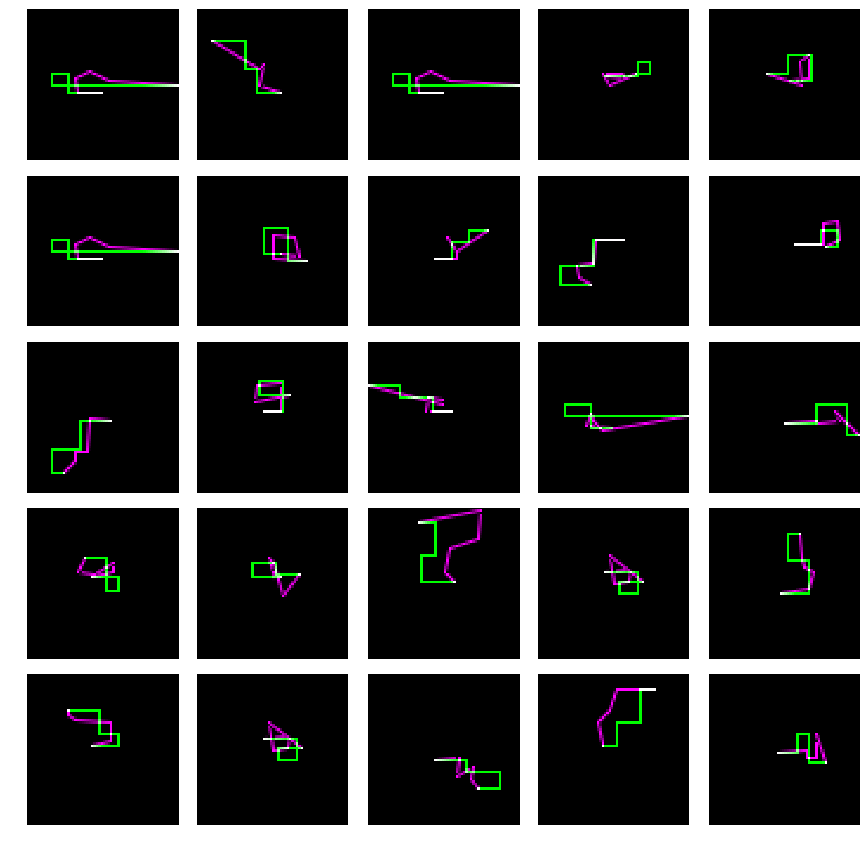

In [1225]:
gridsz = 5
s = np.random.choice(np.arange(0,128),gridsz * gridsz)
pred = predim[s,:,:]
tru = xtst[s,:,:,:,:]

pred[pred>63] = 63 #clip to bbox
pred[pred<0] = 0 #clip to bbox

plt.figure(figsize=(15,15))
for i in range(0,gridsz):
    for j in range(0,gridsz):
        plt.subplot2grid((gridsz,gridsz), (i,j))
        tmp2 = get_shape_from_coord(xy=pred[i*gridsz + j,:,:])
        tmp2[:,:,1] = tru[i*gridsz + j,0,:,:,0]
        fig = plt.imshow(tmp2)
        plt.axis('off')
        plt.subplots_adjust(wspace=.1, hspace=.1)
plt.show()    

In [1233]:
pred.shape

(25, 6, 2)

## PyTorch Land

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import time
import os
import copy

plt.ion()  

### Reimplementation of Tim's CNN autoencoder

In [34]:

'''
Define network

Conv
Maxpool
Conv
Maxpool
Conv
Maxpool
-----
TransposeConv+Upsample
TransposeConv+Upsample
TransposeConv+Upsample

'''

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 8, 3,padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(8, 16, 3,padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(16, 32, 3,padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2)
        )
            
        self.decoder = nn.Sequential(             
            nn.ConvTranspose2d(32,16,kernel_size=2, stride=2),
            nn.ReLU(True),
     
            nn.ConvTranspose2d(16,8,kernel_size=2, stride=2),
            nn.ReLU(True),
      
            nn.ConvTranspose2d(8,3,kernel_size=2, stride=2),
            nn.Sigmoid()
        )
        
        
    def forward(self,x):
        
        x = self.encoder(x)
        x = self.decoder(x)
        return x


net = Net().cpu()


In [35]:
net

Net(
  (encoder): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(32, 16, kernel_size=(2, 2), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): ConvTranspose2d(16, 8, kernel_size=(2, 2), stride=(2, 2))
    (3): ReLU(inplace=True)
    (4): ConvTranspose2d(8, 3, kernel_size=(2, 2), stride=(2, 2))
    (5): Sigmoid()
  )
)

In [36]:
import torch.optim as optim

criterion =  nn.BCELoss()
optimizer = optim.Adam(net.parameters(),weight_decay=1e-5)




In [48]:
import random


bsize = 2000
ns=5
picsz=64

xtrn = np.zeros(shape=(bsize, ns, picsz, picsz, 3))
xtst = np.zeros(shape = (bsize, ns, picsz, picsz, 3))

#Get a batch of training data
xtrn, ytrn = get_batch(bsize, ns = 5, picsize=picsz, minlen = 5, maxlen = 15)

#ytrn = y1.astype('float32')[:,1:6,:] - y1.astype('float32')[:,0:5,:]
#for i in np.arange(0,ns):
#    xtrn[:,i,:,:] = x1 #Copy input image to each timeslice


#Get a batch of testing data
xtst, ytst = get_batch(bsize, ns = 5, picsize=picsz, minlen = 5, maxlen = 15)
#ytst = y2.astype('float32')[:,1:6,:] - y2.astype('float32')[:,0:5,:]
#for i in np.arange(0,ns):
#    xtst[:,i,:,:] = x2 #Copy input image to each timeslice


In [49]:

class sketchdata(Dataset):
    def __init__(self, _x,_y,transform=None):
        self.samples=[]
        self.transform = transform
        for sketch in _x:
            self.samples.append(np.asarray(sketch))
        
    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        #return 
        samples = self.samples[idx]
        
        if self.transform:
            samples = self.transform(samples)

        return samples

In [52]:
trainset =  sketchdata(xtrn,xtrn, transform=transforms.ToTensor() )
testset = sketchdata(xtst,xtst, transform=transforms.ToTensor())

In [24]:
class ToTensorCustom(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        _x, _y = sample

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        print(_x.shape)
        _x = _x.transpose((2, 0, 1))
        _y = _y.transpose((2, 0, 1))
        return ((_x,_y))

In [53]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,shuffle=True, num_workers=4)
testloader = torch.utils.data.DataLoader(testset,batch_size=1, shuffle=False, num_workers=4)

In [59]:
for epoch in range(15):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs= data.float()
       

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, inputs)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 200 == 199:    # print every 200 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 200))
            running_loss = 0.0

print('Finished Training')

[1,   200] loss: 0.004
[1,   400] loss: 0.004
[2,   200] loss: 0.004
[2,   400] loss: 0.003
[3,   200] loss: 0.003
[3,   400] loss: 0.003
[4,   200] loss: 0.003
[4,   400] loss: 0.003
[5,   200] loss: 0.003
[5,   400] loss: 0.002
[6,   200] loss: 0.002
[6,   400] loss: 0.002
[7,   200] loss: 0.002
[7,   400] loss: 0.002
[8,   200] loss: 0.002
[8,   400] loss: 0.002
[9,   200] loss: 0.002
[9,   400] loss: 0.002
[10,   200] loss: 0.002
[10,   400] loss: 0.002
[11,   200] loss: 0.002
[11,   400] loss: 0.002
[12,   200] loss: 0.002
[12,   400] loss: 0.002
[13,   200] loss: 0.001
[13,   400] loss: 0.001
[14,   200] loss: 0.001
[14,   400] loss: 0.001
[15,   200] loss: 0.001
[15,   400] loss: 0.001
Finished Training


In [60]:
# dataiter = iter(testloader)
# images = dataiter.next()

# net.eval()

# output = net(images.float())
# images = images.numpy()


# output = output.view(1, 3,64,64)
# output = output.detach().numpy()

In [61]:
### More efficient way of doing above^
net.eval()
Images = []
Output = []
dataiter = iter(testloader)
for i in range(len(testloader)):
  
    images = dataiter.next()
    output = net(images.float())
    images = images.numpy()
    
    output = output.view(3,64,64)
    output = output.detach().numpy()
    
    Images.append(images)
    Output.append(output)
    

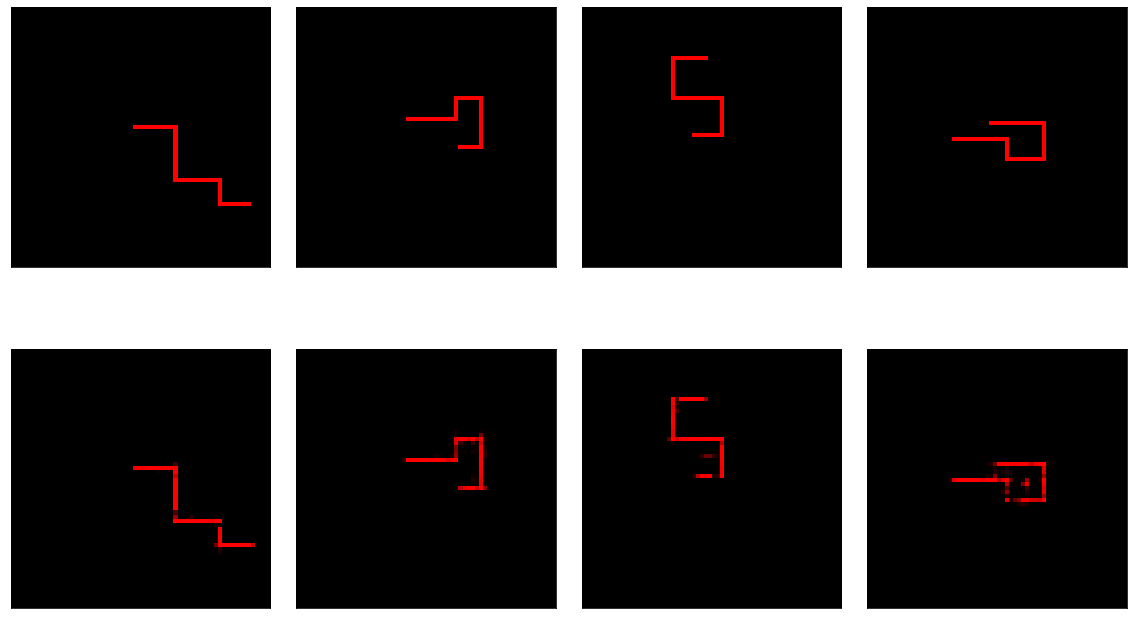

In [62]:
Images = np.stack(np.squeeze(Images))
Output = np.stack(Output)
# plot the first ten input images and then reconstructed images
fig, axes = plt.subplots(nrows=2, ncols=4, sharex=True, sharey=True, figsize=(20,12))

# input images on top row, reconstructions on bottom
for images, row in zip([Images, Output], axes):
    for img, ax in zip(images, row):
        ax.imshow(np.transpose(img, (1, 2, 0)))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
plt.subplots_adjust(wspace=.1, hspace=.1)
       

## Import VGG19 and make an encoder object with only relevant layers

In [11]:
import torchvision.models as models

In [12]:
vgg19 = models.vgg19(pretrained=True)

## load model stored locally if needed

In [13]:
###Get a summary of the model

vgg19

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [14]:
#torch.save(vgg19.state_dict(),'vgg19_pretrained.pt')

In [15]:
## Turn off gradients

for param in vgg19.parameters():
            param.requires_grad = False

In [16]:
### get convolutionals layers; might need later

vgg19_feats = vgg19.features

In [17]:
#build encoder object with conv and feature layers

class encoder(nn.Module):
    def __init__(self,vgg19):
        super(encoder, self).__init__()
        self.convolutions =  nn.Sequential(*list(vgg19.features.children())[slice(0, 37)])
        self.classifier = nn.Sequential(*list(vgg19.classifier.children())[slice(0,2)])

    def forward(self, x):
        x = self.convolutions(x)
        x = x.view(-1,25088)
        x = self.classifier(x)
        return(x)

In [18]:
cnn_encoder = encoder(vgg19)

In [39]:
##Generate sketch data with dims that vgg19 expects

bsize = 2000
ns=5
picsz=224

xtrn = np.zeros(shape=(bsize, ns, picsz, picsz, 3))
xtst = np.zeros(shape = (bsize, ns, picsz, picsz, 3))

#Get a batch of training data
xtrn, ytrn = get_batch(bsize,ns=10,picsize=picsz, minlen=50,maxlen=100)
#ytrn = y1.astype('float32')[:,1:6,:] - y1.astype('float32')[:,0:5,:]
#for i in np.arange(0,ns):
#    xtrn[:,i,:,:] = x1 #Copy input image to each timeslice


#Get a batch of testing data
xtst, ytst = get_batch(bsize,ns=10,picsize=picsz, minlen=50,maxlen=100)
#ytst = y2.astype('float32')[:,1:6,:] - y2.astype('float32')[:,0:5,:]
#for i in np.arange(0,ns):
#    xtst[:,i,:,:] = x2 #Copy input image to each timeslice


In [20]:
### Create dataset

In [25]:
trainset =  sketchdata(xtrn,xtrn, transform=transforms.Compose([transforms.ToTensor(),transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])]) )
testset = sketchdata(xtst,xtst,  transform=transforms.Compose([transforms.ToTensor(),transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])]) )

In [26]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,shuffle=True, num_workers=4)
testloader = torch.utils.data.DataLoader(testset,batch_size=1, shuffle=False, num_workers=4)

In [27]:
dataiter = iter(testloader)
i=dataiter.next()

In [28]:
cnn_encoder.eval() ### freeze dropout
out = cnn_encoder(i.float())

In [29]:
i = np.squeeze(i)
i = i.numpy()
i = i.transpose((1,2,0))

In [68]:

plt.imshow(i)
plt.title("input image")


NameError: name 'i' is not defined

In [31]:
out= out.numpy()

In [32]:
out ### encoded output

array([[0.        , 0.        , 0.        , ..., 0.        , 0.34805968,
        1.7227095 ]], dtype=float32)

In [33]:
out.shape

(1, 4096)

## Shape context functions

In [715]:
class ShapeContext(object):

    def __init__(self, nbins_r=5, nbins_theta=12, r_inner=0.1250, r_outer=2.0):
        # number of radius zones
        self.nbins_r = nbins_r
        # number of angles zones
        self.nbins_theta = nbins_theta
        # maximum and minimum radius
        self.r_inner = r_inner
        self.r_outer = r_outer

    def _hungarian(self, cost_matrix):
        """
            Here we are solving task of getting similar points from two paths
            based on their cost matrixes. 
            This algorithm has dificulty O(n^3)
            return total modification cost, indexes of matched points
        """
        row_ind, col_ind = linear_sum_assignment(cost_matrix)
        total = cost_matrix[row_ind, col_ind].sum()
        indexes = zip(row_ind.tolist(), col_ind.tolist())
        return total, indexes

    def get_points_from_img(self, image, threshold=50, simpleto=300, radius=2):
        """
            That is not very good algorithm of choosing path points, but it will work for our case.

            Idea of it is just to create grid and choose points that on this grid.
        """
        if len(image.shape) > 2:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        dst = cv2.Canny(image, threshold, threshold * 3, 3)

        py, px = np.gradient(image)
        # px, py gradients maps shape can be smaller then input image shape
        points = [index for index, val in np.ndenumerate(dst)
                  if val == 255 and index[0] < py.shape[0] and index[1] < py.shape[1]]
        h, w = image.shape

        _radius = radius
        while len(points) > simpleto:
            newpoints = points
            xr = range(0, w, _radius)
            yr = range(0, h, _radius)
            for p in points:
                if p[0] not in yr and p[1] not in xr:
                    newpoints.remove(p)
                    if len(points) <= simpleto:
                        T = np.zeros((simpleto, 1))
                        for i, (y, x) in enumerate(points):
                            radians = math.atan2(py[y, x], px[y, x])
                            T[i] = radians + 2 * math.pi * (radians < 0)
                        return points, np.asmatrix(T)
            _radius += 1

        T = np.zeros((simpleto, 1))
        
        for i, (y, x) in enumerate(points):
            
            radians = math.atan2(py[y, x], px[y, x])
            
            T[i] = radians + 2 * math.pi * (radians < 0)

        return points, np.asmatrix(T)

    def _cost(self, hi, hj):
        cost = 0
        for k in range(self.nbins_theta * self.nbins_r):
            if (hi[k] + hj[k]):
                cost += ((hi[k] - hj[k])**2) / (hi[k] + hj[k])

        return cost * 0.5

    def cost_by_paper(self, P, Q, qlength=None):
        p, _ = P.shape
        p2, _ = Q.shape
        d = p2
        if qlength:
            d = qlength
        C = np.zeros((p, p2))
        for i in range(p):
            for j in range(p2):
                C[i, j] = self._cost(Q[j] / d, P[i] / p)

        return C

    def compute(self, points):
        """
          Here we are computing shape context descriptor
        """
        t_points = len(points)
        # getting euclidian distance
        r_array = cdist(points, points)
        # getting two points with maximum distance to norm angle by them
        # this is needed for rotation invariant feature
        am = r_array.argmax()
        max_points = [am // t_points, am % t_points]
        # normalizing
        r_array_n = r_array / r_array.mean()
        # create log space
        r_bin_edges = np.logspace(np.log10(self.r_inner), np.log10(self.r_outer), self.nbins_r)
        r_array_q = np.zeros((t_points, t_points), dtype=int)
        # summing occurences in different log space intervals
        # logspace = [0.1250, 0.2500, 0.5000, 1.0000, 2.0000]
        # 0    1.3 -> 1 0 -> 2 0 -> 3 0 -> 4 0 -> 5 1
        # 0.43  0     0 1    0 2    1 3    2 4    3 5
        for m in range(self.nbins_r):
            r_array_q += (r_array_n < r_bin_edges[m])

        fz = r_array_q > 0

        # getting angles in radians
        theta_array = cdist(points, points, lambda u, v: math.atan2((v[1] - u[1]), (v[0] - u[0])))
        norm_angle = theta_array[max_points[0], max_points[1]]
        # making angles matrix rotation invariant
        theta_array = (theta_array - norm_angle * (np.ones((t_points, t_points)) - np.identity(t_points)))
        # removing all very small values because of float operation
        theta_array[np.abs(theta_array) < 1e-7] = 0

        # 2Pi shifted because we need angels in [0,2Pi]
        theta_array_2 = theta_array + 2 * math.pi * (theta_array < 0)
        # Simple Quantization
        theta_array_q = (1 + np.floor(theta_array_2 / (2 * math.pi / self.nbins_theta))).astype(int)

        # building point descriptor based on angle and distance
        nbins = self.nbins_theta * self.nbins_r
        descriptor = np.zeros((t_points, nbins))
        for i in range(t_points):
            sn = np.zeros((self.nbins_r, self.nbins_theta))
            for j in range(t_points):
                if (fz[i, j]):
                    sn[r_array_q[i, j] - 1, theta_array_q[i, j] - 1] += 1
            descriptor[i] = sn.reshape(nbins)

        return descriptor

    def cosine_diff(self, P, Q):
        """
            Fast cosine diff.
        """
        P = P.flatten()
        Q = Q.flatten()
        assert len(P) == len(Q), 'number of descriptors should be the same'
        return cosine(P, Q)

    def diff(self, P, Q, qlength=None):
        """
            More precise but not very speed efficient diff.

            if Q is generalized shape context then it compute shape match.

            if Q is r point representative shape contexts and qlength set to 
            the number of points in Q then it compute fast shape match.

        """
        result = None
        C = self.cost_by_paper(P, Q, qlength)

        result = self._hungarian(C)

        return result

    @classmethod
    def tests(cls):
        # basics tests to see that all algorithm invariants options are working fine
        self = cls()

        def test_move():
            p1 = np.array([
                [0, 100],
                [200, 60],
                [350, 220],
                [370, 100],
                [70, 300],
            ])
            # +30 by x
            p2 = np.array([
                [0, 130],
                [200, 90],
                [350, 250],
                [370, 130],
                [70, 330]
            ])
            c1 = self.compute(p1)
            c2 = self.compute(p2)
            assert (np.abs(c1.flatten() - c2.flatten())
                    ).sum() == 0, "Moving points in 2d space should give same shape context vector"

        def test_scale():
            p1 = np.array([
                [0, 100],
                [200, 60],
                [350, 220],
                [370, 100],
                [70, 300],
            ])
            # 2x scaling
            p2 = np.array([
                [0, 200],
                [400, 120],
                [700, 440],
                [740, 200],
                [149, 600]
            ])
            c1 = self.compute(p1)
            c2 = self.compute(p2)
            assert (np.abs(c1.flatten() - c2.flatten())
                    ).sum() == 0, "Scaling points in 2d space should give same shape context vector"

        def test_rotation():
            p1 = np.array(
                [(144, 196), (220, 216), (330, 208)]
            )
            # 90 degree rotation
            theta = np.radians(90)
            c, s = np.cos(theta), np.sin(theta)
            R = np.matrix('{} {}; {} {}'.format(c, -s, s, c))
            p2 = np.dot(p1, R).tolist()

            c1 = self.compute(p1)
            c2 = self.compute(p2)
            assert (np.abs(c1.flatten() - c2.flatten())
                    ).sum() == 0, "Rotating points in 2d space should give same shape context vector"

        test_move()
        test_scale()
        test_rotation()
        print ('Tests PASSED')


ShapeContext.tests()


Tests PASSED


In [716]:
import urllib.request

In [717]:
urllib.request.urlretrieve('https://raw.githubusercontent.com/creotiv/Python-Shape-Context/master/A.png', 'test.png')
urllib.request.urlretrieve('https://raw.githubusercontent.com/creotiv/Python-Shape-Context/master/A2.png', 'test2.png')
urllib.request.urlretrieve('https://raw.githubusercontent.com/creotiv/Python-Shape-Context/master/AM.png', 'test3.png')
urllib.request.urlretrieve('https://raw.githubusercontent.com/creotiv/Python-Shape-Context/master/AM2.png', 'test4.png')
urllib.request.urlretrieve('https://raw.githubusercontent.com/creotiv/Python-Shape-Context/master/AM3.png', 'test5.png')
urllib.request.urlretrieve('https://raw.githubusercontent.com/creotiv/Python-Shape-Context/master/B.png', 'test6.png')
urllib.request.urlretrieve('https://raw.githubusercontent.com/creotiv/Python-Shape-Context/master/9.png', 'test7.png')
urllib.request.urlretrieve('https://raw.githubusercontent.com/creotiv/computer_vision/master/resources/sc/numbers.png', 'numbers.png')
urllib.request.urlretrieve('https://raw.githubusercontent.com/creotiv/computer_vision/master/resources/sc/numbers_test1.png', 'numbers_test1.png')
urllib.request.urlretrieve('https://raw.githubusercontent.com/creotiv/computer_vision/master/resources/sc/numbers_test2.png', 'numbers_test3.png')
urllib.request.urlretrieve('https://raw.githubusercontent.com/creotiv/computer_vision/master/resources/sc/numbers_test3.png', 'numbers_test3.png')

('numbers_test3.png', <http.client.HTTPMessage at 0x14aefc310>)

In [718]:
def plot(img, img2, rotate=False):
    sc = ShapeContext()
    sampls = 300

    points1,t1 = sc.get_points_from_img(img,simpleto=sampls)
    points2,t2 = sc.get_points_from_img(img2,simpleto=sampls)
    points2 = (np.array(points2)+30).tolist()

    if rotate:
        # https://docs.opencv.org/3.0-beta/doc/py_tutorials/py_imgproc/py_geometric_transformations/py_geometric_transformations.html
        theta = np.radians(90)
        c, s = np.cos(theta), np.sin(theta)
        R = np.matrix('{} {}; {} {}'.format(c, -s, s, c))
        points2 = np.dot(np.array(points2), R).tolist()

    P = sc.compute(points1)
    print (P[0])
    x1 = [p[1] for p in points1]
    y1 = [p[0] for p in points1]
    Q = sc.compute(points2)
    x2 = [p[1] for p in points2]
    y2 = [p[0] for p in points2]

    standard_cost,indexes = sc.diff(P,Q)
    
    lines = []
    for p,q in indexes:
        lines.append(((points1[p][1],points1[p][0]), (points2[q][1],points2[q][0])))
        
    fig = plt.figure(figsize=(20,10))
    #ax = plt.subplot(121)
    ax = fig.add_subplot(121)
    plt.gca().invert_yaxis()
    plt.plot(x1,y1,'go', x2,y2, 'ro')
    
    #ax = plt.subplot(122)
    ax = fig.add_subplot(122)
    plt.gca().invert_yaxis()
    plt.plot(x1,y1,'go',x2,y2,'ro')
    for p1,p2 in lines:   
        plt.gca().invert_yaxis()
        plt.plot((p1[0],p2[0]),(p1[1],p2[1]), 'k-')
    plt.show()
    print ("Cosine diff:", cosine(P.flatten(), Q.flatten()))
    print ("Standard diff:", standard_cost)

  

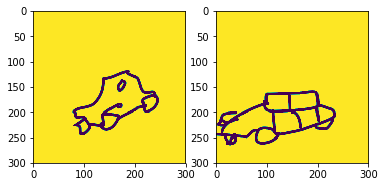

[42. 78. 33. 32.  4.  0.  0.  0.  0.  0.  0.  0. 14.  6.  7. 18.  4.  0.
  0.  0.  0.  0.  0.  1.  5.  5. 12.  2.  5.  0.  0.  0.  0.  0.  0.  0.
  0.  2.  0.  2.  2.  0.  0.  0.  0.  0.  0.  1.  1.  0.  2.  0.  0.  0.
  0.  0.  0.  0.  0.  2.]


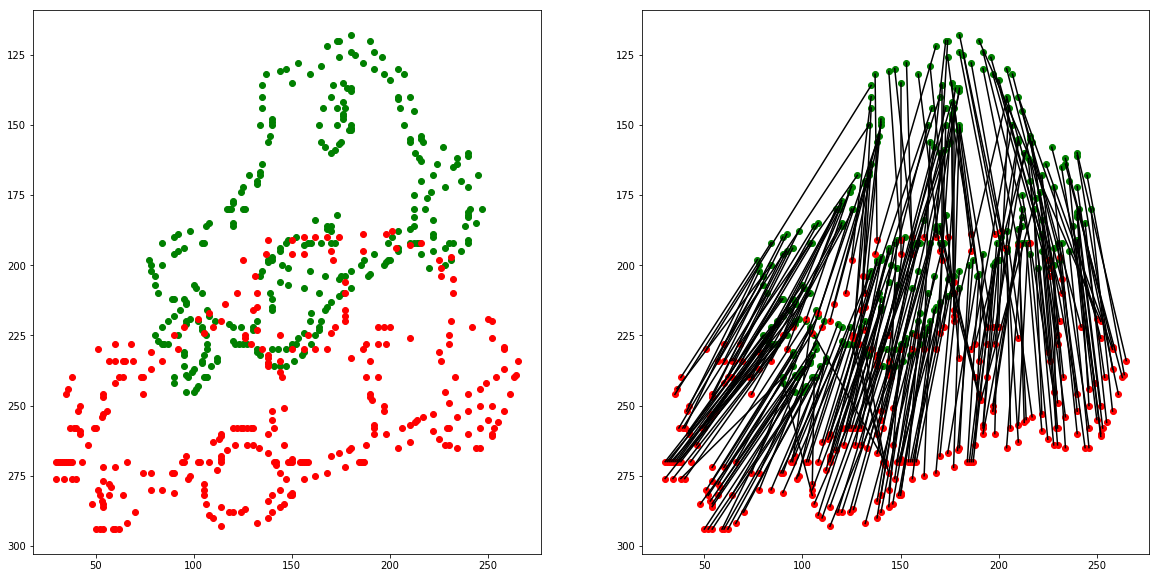

Cosine diff: 0.384506365253675
Standard diff: 47.78758634597239


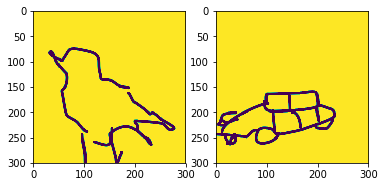

[ 0.  0.  0.  0.  0.  0.  0.  0.  0. 11. 89. 80.  0.  0.  0.  0.  0.  0.
  0.  0.  0. 15.  0. 21. 12.  0.  0.  0.  0.  0.  0.  6.  8.  4.  0.  3.
  0.  0.  0.  0.  0.  0.  0.  3.  2.  0.  0.  0.  2.  0.  0.  0.  0.  0.
  0.  0.  1.  0.  1.  1.]


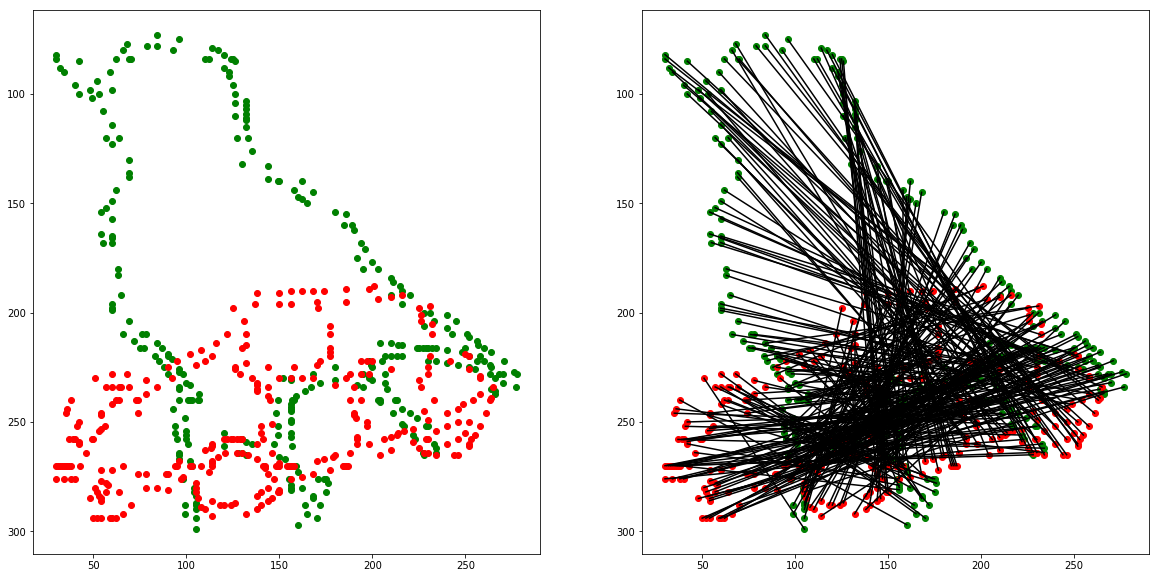

Cosine diff: 0.7515152726479897
Standard diff: 97.03672245893605


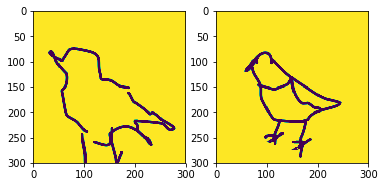

[ 0.  0.  0.  0.  0.  0.  0.  0.  0. 11. 89. 80.  0.  0.  0.  0.  0.  0.
  0.  0.  0. 15.  0. 21. 12.  0.  0.  0.  0.  0.  0.  6.  8.  4.  0.  3.
  0.  0.  0.  0.  0.  0.  0.  3.  2.  0.  0.  0.  2.  0.  0.  0.  0.  0.
  0.  0.  1.  0.  1.  1.]


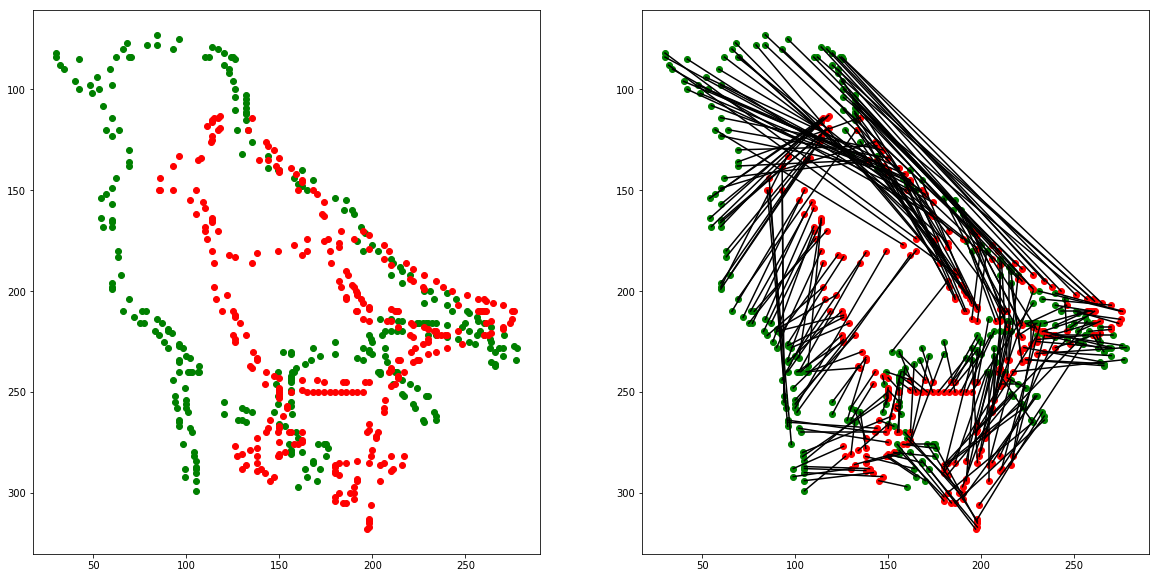

Cosine diff: 0.5792750757925175
Standard diff: 103.57169184315478


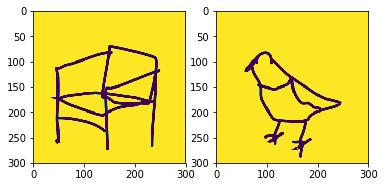

[64. 58. 49.  8.  0.  0.  0.  0.  0.  0.  0. 12.  0. 30.  6. 10. 10.  0.
  0.  0.  0.  0.  0.  8.  1.  4.  0.  4.  4.  0.  0.  0.  0.  0.  0.  4.
  2.  2.  0.  2.  2.  0.  0.  0.  0.  0.  0.  0.  1.  1.  0.  0.  1.  0.
  0.  0.  0.  0.  0.  1.]


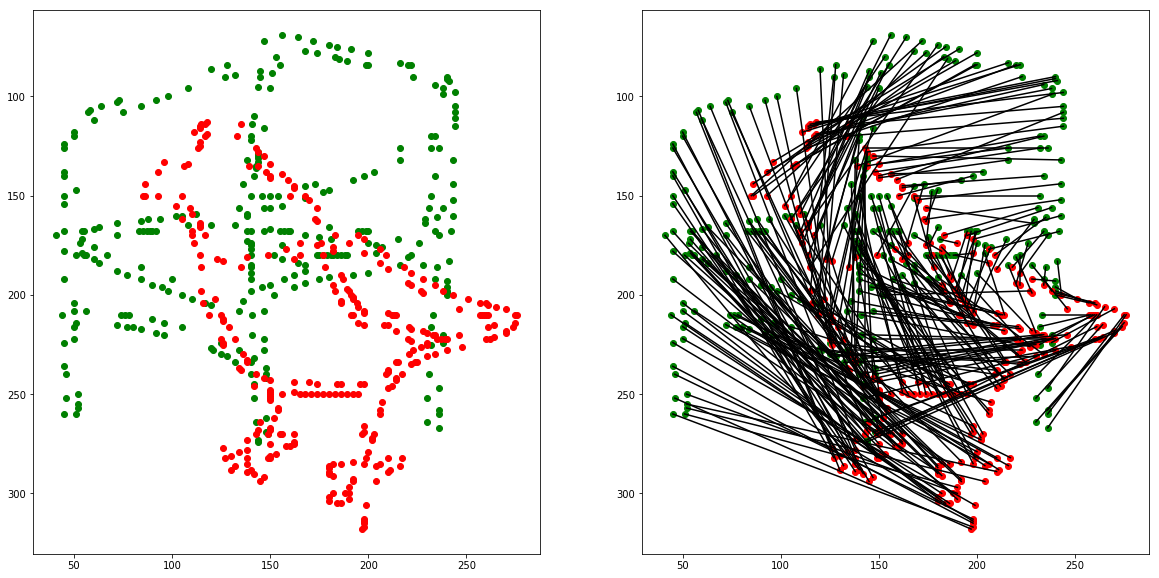

Cosine diff: 0.5622261959692848
Standard diff: 67.83155541338552
[32.  0.  0.  0.  0.  0.  0.  0.  0.  0. 33. 83. 13.  0.  0.  0.  0.  0.
  0.  0.  0.  0. 13. 12.  4.  0.  0.  0.  0.  0.  0.  0.  0.  0.  6.  0.
  0.  6.  0.  0.  0.  0.  0.  0.  0.  2.  1.  0.  1.  0.  1.  0.  0.  0.
  0.  0.  2.  1.  0.  0.]


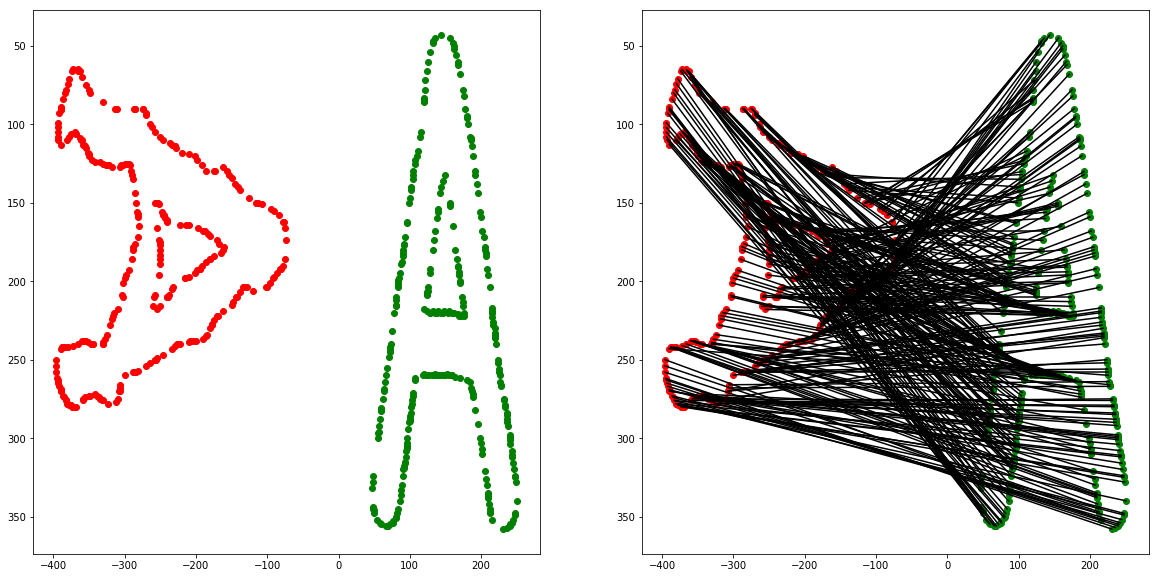

Cosine diff: 0.43544403874471493
Standard diff: 29.33002758348514


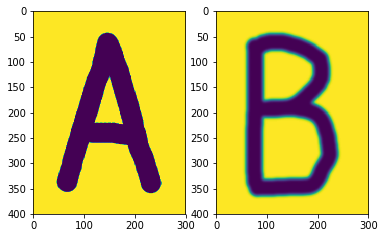

[32.  0.  0.  0.  0.  0.  0.  0.  0.  0. 33. 83. 13.  0.  0.  0.  0.  0.
  0.  0.  0.  0. 13. 12.  4.  0.  0.  0.  0.  0.  0.  0.  0.  0.  6.  0.
  0.  6.  0.  0.  0.  0.  0.  0.  0.  2.  1.  0.  1.  0.  1.  0.  0.  0.
  0.  0.  2.  1.  0.  0.]


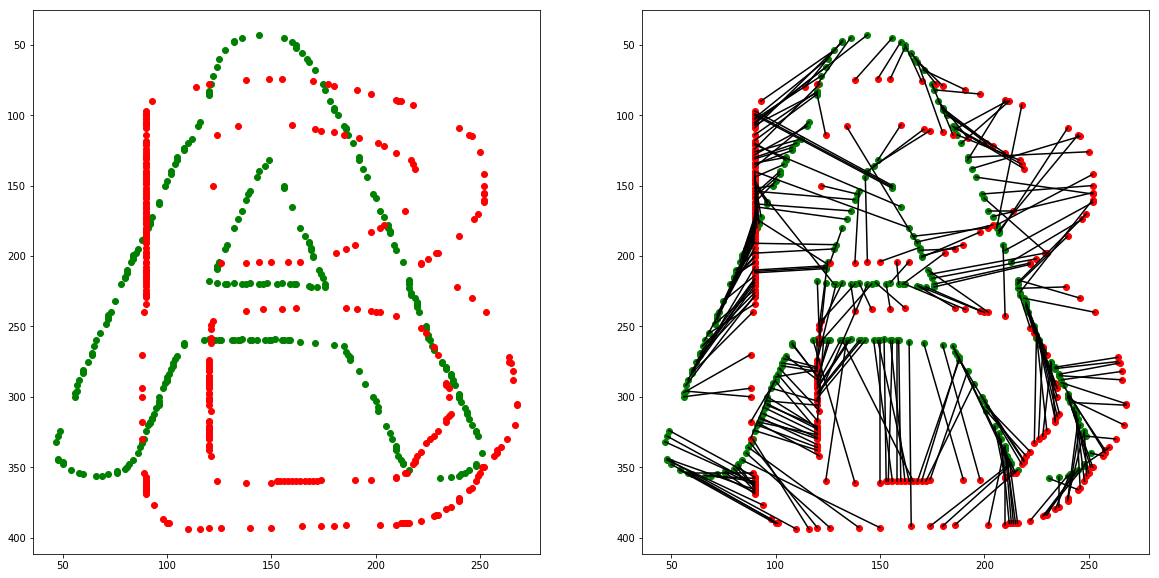

Cosine diff: 0.47828376030841546
Standard diff: 85.34943038363272


In [70]:
img = cv2.imread('car.png', 0)
img2 = cv2.imread('car2.png', 0)
plt.subplot(121)
plt.imshow(img)
plt.subplot(122)
plt.imshow(img2)
plt.show()
plot(img, img2)


img = cv2.imread('bird.png', 0)
img2 = cv2.imread('car2.png', 0)
plt.subplot(121)
plt.imshow(img)
plt.subplot(122)
plt.imshow(img2)
plt.show()
plot(img, img2)


img = cv2.imread('bird.png', 0)
img2 = cv2.imread('bird2.png', 0)
plt.subplot(121)
plt.imshow(img)
plt.subplot(122)
plt.imshow(img2)
plt.show()
plot(img, img2)

img = cv2.imread('chair.png', 0)
img2 = cv2.imread('bird2.png', 0)
plt.subplot(121)
plt.imshow(img)
plt.subplot(122)
plt.imshow(img2)
plt.show()
plot(img, img2)


img = cv2.imread('test.png', 0)
img2 = cv2.imread('test3.png', 0)
# with 90 degree rotation
plot(img, img2, rotate=True)

img = cv2.imread('test.png', 0)
img2 = cv2.imread('test6.png', 0)
plt.subplot(121)
plt.imshow(img)
plt.subplot(122)
plt.imshow(img2)
plt.show()
plot(img, img2)


In [745]:
np.uint8(o[:,:,0])*255


array([[255, 255, 255, 255,   0,   0,   0,   0,   0,   0,   0],
       [255,   0,   0, 255,   0,   0,   0,   0,   0,   0,   0],
       [255,   0,   0, 255,   0,   0,   0,   0,   0,   0,   0],
       [255, 255, 255, 255, 255, 255, 255,   0,   0,   0,   0],
       [  0,   0,   0, 255,   0,   0, 255,   0,   0,   0,   0],
       [  0,   0,   0, 255,   0,   0, 255,   0,   0,   0,   0],
       [  0,   0,   0, 255, 255, 255, 255,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0]],
      dtype=uint8)

In [746]:
img

array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)

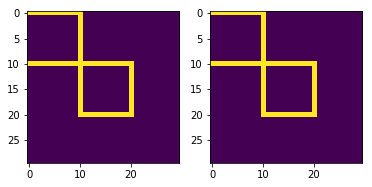

[24.  2.  0.  0.  0.  0.  0.  0.  0.  0.  4. 29.  3.  4.  0.  0.  0.  0.
  0.  0.  0.  0.  3.  2.  0.  3.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.]


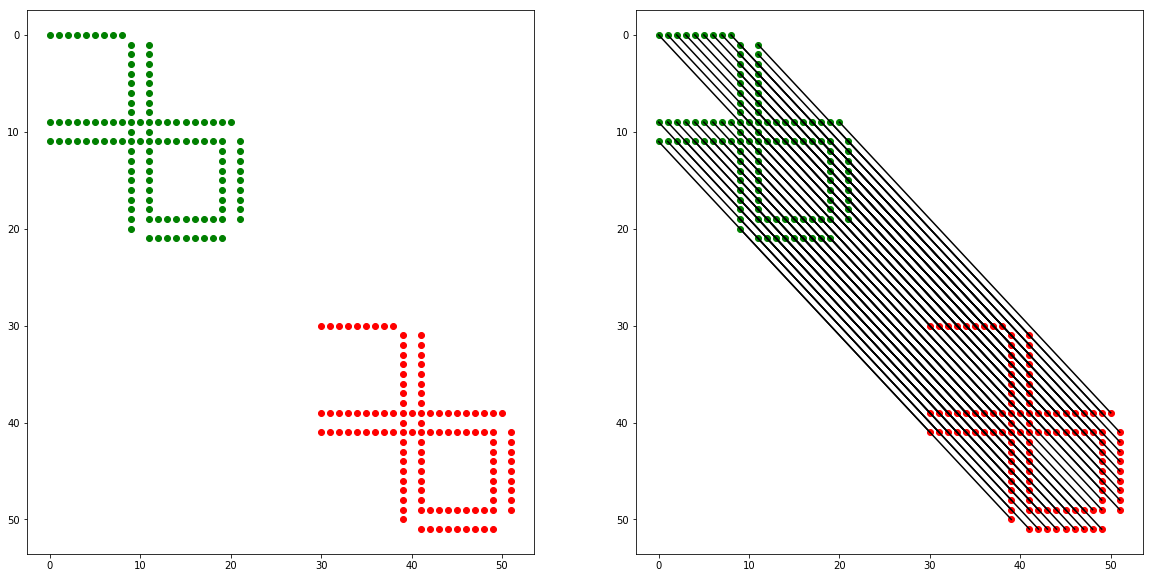

Cosine diff: 0.0
Standard diff: 0.0


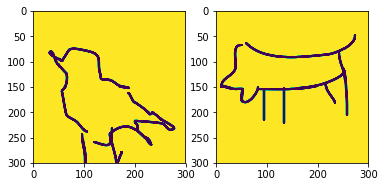

[ 0.  0.  0.  0.  0.  0.  0.  0.  0. 11. 89. 80.  0.  0.  0.  0.  0.  0.
  0.  0.  0. 15.  0. 21. 12.  0.  0.  0.  0.  0.  0.  6.  8.  4.  0.  3.
  0.  0.  0.  0.  0.  0.  0.  3.  2.  0.  0.  0.  2.  0.  0.  0.  0.  0.
  0.  0.  1.  0.  1.  1.]


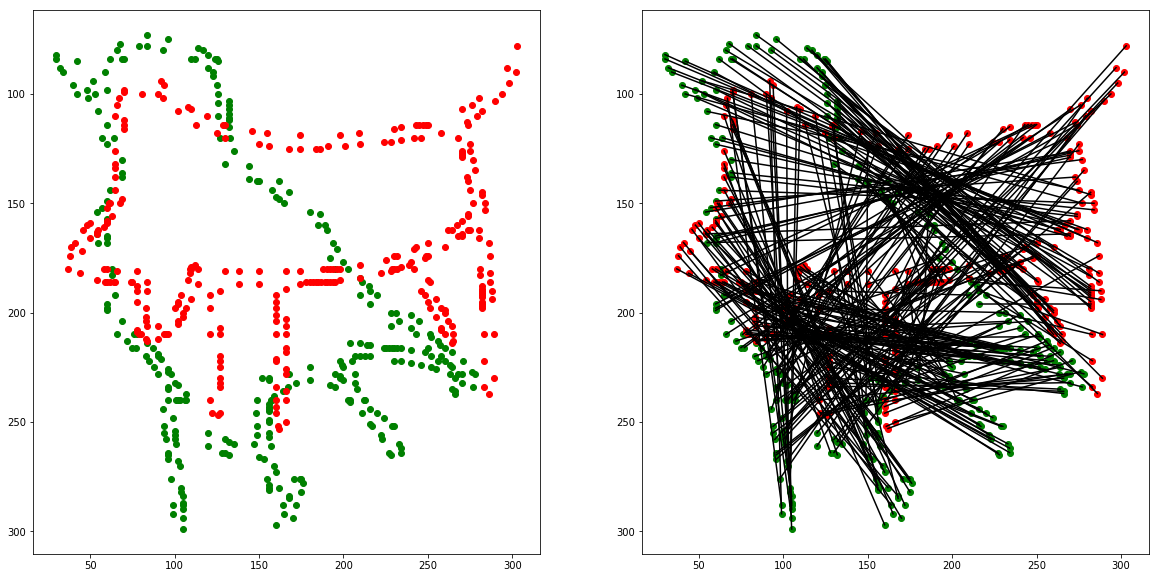

Cosine diff: 0.7416076930016005
Standard diff: 105.75546730910445


In [757]:
#img = cv2.imread('bird.png', 0)
img = np.uint8(o[:,:,0])*255
#img2 = cv2.imread('chair.png', 0)
img2 = np.uint8(o[:,:,0])*255
plt.subplot(121)
plt.imshow(img)
plt.subplot(122)
plt.imshow(img2)
plt.show()
plot(img, img2)

img = cv2.imread('bird.png', 0)
img2 = cv2.imread('dog.png', 0)
plt.subplot(121)
plt.imshow(img)
plt.subplot(122)
plt.imshow(img2)
plt.show()
plot(img, img2)


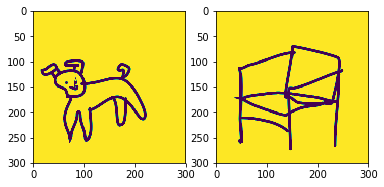

[25.  0.  0.  0.  0.  0.  0.  0.  0. 32. 47. 78.  1.  0.  0.  0.  0.  0.
  0. 12.  7. 13. 18. 14.  3.  0.  0.  0.  0.  0.  0.  3.  9.  2.  8.  3.
  1.  0.  0.  0.  0.  0.  0.  4.  1.  4.  3.  3.  4.  0.  0.  0.  0.  0.
  0.  0.  1.  0.  2.  0.]


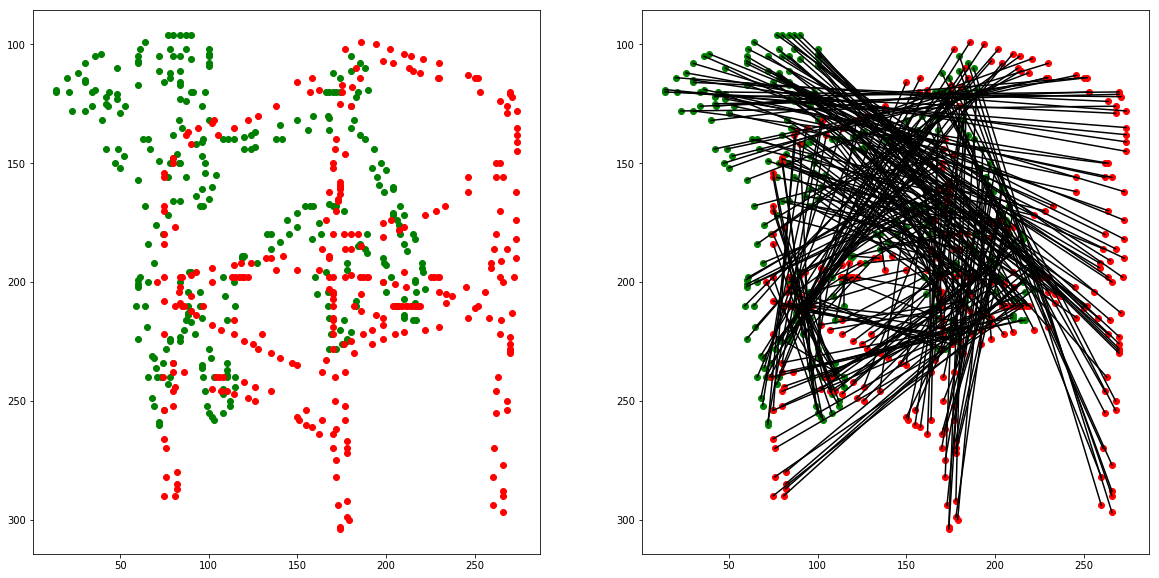

Cosine diff: 0.6925857679597356
Standard diff: 72.63749136028554


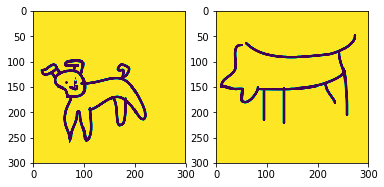

[25.  0.  0.  0.  0.  0.  0.  0.  0. 32. 47. 78.  1.  0.  0.  0.  0.  0.
  0. 12.  7. 13. 18. 14.  3.  0.  0.  0.  0.  0.  0.  3.  9.  2.  8.  3.
  1.  0.  0.  0.  0.  0.  0.  4.  1.  4.  3.  3.  4.  0.  0.  0.  0.  0.
  0.  0.  1.  0.  2.  0.]


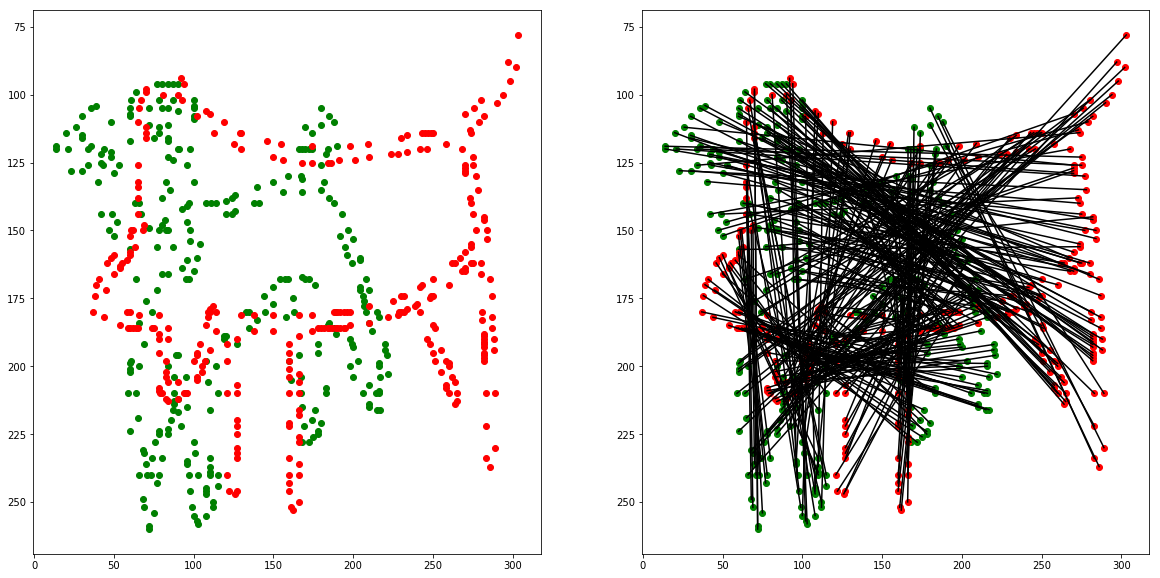

Cosine diff: 0.7382809008305196
Standard diff: 91.8348024350704


In [72]:
img = cv2.imread('dog2.png', 0)
img2 = cv2.imread('chair.png', 0)
plt.subplot(121)
plt.imshow(img)
plt.subplot(122)
plt.imshow(img2)
plt.show()
plot(img, img2)

img = cv2.imread('dog2.png', 0)
img2 = cv2.imread('dog.png', 0)
plt.subplot(121)
plt.imshow(img)
plt.subplot(122)
plt.imshow(img2)
plt.show()
plot(img, img2)
